In [1]:
import pandas as pd
import numpy as np
import re
# --------------------
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
import math
import unidecode

In [2]:
df = pd.read_csv('data_defi3.csv.gz',compression="gzip", sep=";")

In [3]:
print(df.info())
print(df['PLT'].unique())
print(df['PLT'].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23514 entries, 0 to 23513
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Libellé.Prescription  23514 non-null  object 
 1   Avis.Pharmaceutique   23141 non-null  object 
 2   PLT                   23514 non-null  float64
dtypes: float64(1), object(2)
memory usage: 551.2+ KB
None
[ 5.3  4.1  3.1 10.   1.2  1.1  5.1  8.5  6.4  2.2 11.   8.4  6.2  4.2
  9.1  8.1  8.3  6.1  3.2  2.4  8.2  5.2  1.3  2.1  6.3  7. ]
26


In [4]:
df.dropna(inplace=True)

In [18]:
df.head()

,Libellé.Prescription,Avis.Pharmaceutique,PLT,Length
0,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30 12 16 indication,1,26
1,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)",22 12 16 recommande imovane 3 75mg cp 1 coucher eb,1,59
2,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)",vue dfg recommande administrer 1mg 48h donnees gpr veuillez reevaluer prescription ab,1,113
3,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPANTOL)",dose curative absence atcd gastrique retrouve recommande reduire posologie 20 mg jour,1,108
4,VANCOMYCINE 500 mg 1x/j,posologie infrat veuillez reevaluer posologie proposons 30mg kg ab,0,77


In [6]:
import unidecode

In [7]:
#unaccented_string = unidecode.unidecode(df['Avis.Pharmaceutique'][2])
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x : unidecode.unidecode(x)) # Remove é etc and ponctuation

In [8]:
chars = [4,4.1,4.2,5,5.1,5.2,5.3,6.3,6.4]
   

In [9]:
chars = [4,4.1,4.2,5,5.1,5.2,5.3,6.3,6.4]
for x in df['PLT']:
    if x not in chars:
        df['PLT'].replace(x, 0,inplace=True)
for c in chars:
    df['PLT'].replace(c, 1,inplace=True)

In [10]:
df['Length'] = df['Avis.Pharmaceutique'].str.len()

In [11]:
df.groupby('PLT').describe()

Length                                                     
       count       mean        std  min   25%   50%    75%    max
PLT                                                              
0.0  18613.0  81.381722  42.408490  2.0  51.0  73.0  102.0  455.0
1.0   4528.0  88.431316  49.519892  6.0  54.0  75.0  115.0  323.0

<AxesSubplot:ylabel='Frequency'>

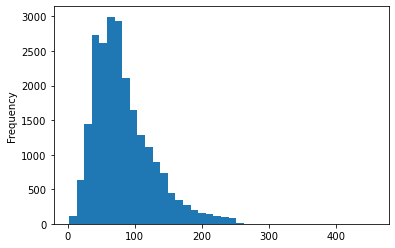

In [12]:
df['Length'].plot(bins=40, kind='hist') 

In [13]:
df.dropna(inplace=True)
df['PLT'] = df['PLT'].apply(lambda x : math.floor(x))

In [14]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z0-9]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [15]:
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x : preprocess_text(x))
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].str.lower()

In [16]:
stop_word = ["a","abord","absolument","afin","ah","ai","aie","aient","aies","ailleurs","ainsi","ait","allaient",
             "allo","allons","allô","alors","anterieur","anterieure","anterieures","apres","après","as","assez",
             "attendu","au","aucun","aucune","aucuns","aujourd","aujourd'hui","aupres","auquel","aura","aurai",
             "auraient","aurais","aurait","auras","aurez","auriez","aurions","aurons","auront","aussi","autant",
             "autre","autrefois","autrement","autres","autrui","aux","auxquelles","auxquels","avaient","avais",
             "avait","avant","avec","avez","aviez","avions","avoir","avons","ayant","ayez","ayons","b","bah",
             "bas","basee","bat","beau","beaucoup","bien","bigre","bon","boum","bravo","brrr","c","car","ce",
             "ceci","cela","celle","celle-ci","celle-là","celles","celles-ci","celles-là","celui","celui-ci",
             "celui-là","celà","cent","cependant","certain","certaine","certaines","certains","certes","ces",
             "cet","cette","ceux","ceux-ci","ceux-là","chacun","chacune","chaque","cher","chers","chez","chiche",
             "chut","chère","chères","ci","cinq","cinquantaine","cinquante","cinquantième","cinquième","clac","clic",
             "combien","comme","comment","comparable","comparables","compris","concernant","contre","couic",
             "crac","d","da","dans","de","debout","dedans","dehors","deja","delà","depuis","dernier","derniere",
             "derriere","derrière","des","desormais","desquelles","desquels","dessous","dessus","deux","deuxième",
             "deuxièmement","devant","devers","devra","devrait","different","differentes","differents","différent",
             "différente","différentes","différents","dire","directe","directement","dit","dite","dits","divers",
             "diverse","diverses","dix","dix-huit","dix-neuf","dix-sept","dixième","doit","doivent","donc","dont",
             "dos","douze","douzième","dring","droite","du","duquel","durant","dès","début","désormais","e","effet",
             "egale","egalement","egales","eh","elle","elle-même","elles","elles-mêmes","en","encore","enfin","entre","envers","environ","es","essai","est","et","etant","etc","etre","eu","eue","eues","euh","eurent","eus","eusse","eussent","eusses","eussiez","eussions","eut","eux","eux-mêmes","exactement","excepté","extenso","exterieur","eûmes","eût","eûtes","f","fais","faisaient","faisant","fait","faites","façon","feront","fi","flac","floc","fois","font","force","furent","fus","fusse","fussent","fusses","fussiez","fussions","fut","fûmes","fût","fûtes","g","gens","h","ha","haut","hein","hem","hep","hi","ho","holà","hop","hormis","hors","hou","houp","hue","hui","huit","huitième","hum","hurrah","hé","hélas","i","ici","il","ils","importe","j","je","jusqu","jusque","juste","k","l","la","laisser","laquelle","las","le","lequel","les","lesquelles","lesquels","leur","leurs","longtemps","lors","lorsque","lui","lui-meme","lui-même","là","lès","m","ma","maint","maintenant","mais","malgre","malgré","maximale","me","meme","memes","merci","mes","mien","mienne","miennes","miens","mille","mince","mine","minimale","moi","moi-meme","moi-même","moindres","moins","mon","mot","moyennant","multiple","multiples","même","mêmes","n","na","naturel","naturelle","naturelles","ne","neanmoins","necessaire","necessairement","neuf","neuvième","ni","nombreuses","nombreux","nommés","non","nos","notamment","notre","nous","nous-mêmes","nouveau","nouveaux","nul","néanmoins","nôtre","nôtres","o","oh","ohé","ollé","olé","on","ont","onze","onzième","ore","ou","ouf","ouias","oust","ouste","outre","ouvert","ouverte","ouverts","o|","où","p","paf","pan","par","parce","parfois","parle","parlent","parler","parmi","parole","parseme","partant","particulier","particulière","particulièrement","pas","passé","pendant","pense","permet","personne","personnes","peu","peut","peuvent","peux","pff","pfft","pfut","pif","pire","pièce","plein","plouf","plupart","plus","plusieurs","plutôt","possessif","possessifs","possible","possibles","pouah","pour","pourquoi","pourrais","pourrait","pouvait","prealable","precisement","premier","première","premièrement","pres","probable","probante","procedant","proche","près","psitt","pu","puis","puisque","pur","pure","q","qu","quand","quant","quant-à-soi","quanta","quarante","quatorze","quatre","quatre-vingt","quatrième","quatrièmement","que","quel","quelconque","quelle","quelles","quelqu'un","quelque","quelques","quels","qui","quiconque","quinze","quoi","quoique","r","rare","rarement","rares","relative","relativement","remarquable","rend","rendre","restant","reste","restent","restrictif","retour","revoici","revoilà","rien","s","sa","sacrebleu","sait","sans","sapristi","sauf","se","sein","seize","selon","semblable","semblaient","semble","semblent","sent","sept","septième","sera","serai","seraient","serais","serait","seras","serez","seriez","serions","serons","seront","ses","seul","seule","seulement","si","sien","sienne","siennes","siens","sinon","six","sixième","soi","soi-même","soient","sois","soit","soixante","sommes","son","sont","sous","souvent","soyez","soyons","specifique","specifiques","speculatif","stop","strictement","subtiles","suffisant","suffisante","suffit","suis","suit","suivant","suivante","suivantes","suivants","suivre","sujet","superpose","sur","surtout","t","ta","tac","tandis","tant","tardive","te","tel","telle","tellement","telles","tels","tenant","tend","tenir","tente","tes","tic","tien","tienne","tiennes","tiens","toc","toi","toi-même","ton","touchant","toujours","tous","tout","toute","toutefois","toutes","treize","trente","tres","trois","troisième","troisièmement","trop","très","tsoin","tsouin","tu","té","u","un","une","unes","uniformement","unique","uniques","uns","v","va","vais","valeur","vas","vers","via","vif","vifs","vingt","vivat","vive","vives","vlan","voici","voie","voient","voilà","voire","vont","vos","votre","vous","vous-mêmes","vu","vé","vôtre","vôtres","w","x","y","z","zut","à","â","ça","ès","étaient","étais","était","étant","état","étiez","étions","été","étée","étées","étés","êtes","être","ô"]


In [17]:
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))

In [65]:
def clean_text_plt(df):
    for x in df:
        if x not in chars:
            df.replace(x, 0,inplace=True)
    for c in chars:
        df.replace(c, 1,inplace=True)
   # df = df.apply(lambda x : math.floor(x))
    df.dropna(inplace=True)
    return df

In [77]:
def clean_avis(df):
    df = df.apply(lambda x : preprocess_text(x))
    df = df.str.lower()
    return df

In [78]:
X_train = clean_avis(X_test)

NameError: name 'X_test' is not defined

In [ ]:
X_train

In [206]:
clean_text_plt(y_test)

5363     0.0
5207     1.0
2969     0.0
6328     0.0
9004     1.0
        ... 
6185     1.0
1829     1.0
19405    0.0
381      0.0
10836    1.0
Name: PLT, Length: 6943, dtype: float64

In [128]:
df.head()

,Libellé.Prescription,Avis.Pharmaceutique,PLT,Length
0,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30 12 16 indication,1,26
1,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)",22 12 16 recommand imovane 3 75mg cp 1 coucher eb,1,59
2,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)",vue dfg recommand administrer 1mg 48h donn gpr veuillez valuer prescription ab,1,113
3,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPANTOL)",dose curative absence atcd gastrique retrouv recommand duire posologie 20 mg jour,1,108
4,VANCOMYCINE 500 mg 1x/j,posologie infrat veuillez valuer posologie proposons 30mg kg ab,0,77


#### Frequency of word list

In [134]:
cv = CountVectorizer()
cv_fit = cv.fit_transform(df['Avis.Pharmaceutique'])

In [135]:
word_list = cv.get_feature_names()
count_list = cv_fit.toarray().sum(axis=0)
dict_list = dict(zip(word_list,count_list))
dict_list = sorted(dict_list.items(), key=lambda item: item[1],reverse=True)
dict_list[:20]

C:\Users\Casper\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('17', 7961),
 ('mg', 6268),
 ('jour', 3737),
 ('propose', 3479),
 ('hus', 3252),
 ('cp', 3038),
 ('01', 2931),
 ('02', 2790),
 ('proposons', 2776),
 ('03', 2262),
 ('reference', 2259),
 ('cpr', 2217),
 ('prescrire', 2176),
 ('refuse', 2040),
 ('posologie', 1972),
 ('motif', 1899),
 ('04', 1773),
 ('prescription', 1684),
 ('pantoprazole', 1591),
 ('andrea', 1532)]

#### Simple Way

In [19]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [20]:
X = df['Avis.Pharmaceutique']
y = df['PLT']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state = 42, stratify=y)

In [21]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [22]:
predictions = pipeline.predict(X_test)

In [23]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[5466  118]
 [ 638  721]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5584
           1       0.86      0.53      0.66      1359

    accuracy                           0.89      6943
   macro avg       0.88      0.75      0.80      6943
weighted avg       0.89      0.89      0.88      6943



In [101]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[5482  102]
 [ 614  745]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5584
           1       0.88      0.55      0.68      1359

    accuracy                           0.90      6943
   macro avg       0.89      0.76      0.81      6943
weighted avg       0.90      0.90      0.89      6943



In [135]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[5467  117]
 [ 637  722]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5584
           1       0.86      0.53      0.66      1359

    accuracy                           0.89      6943
   macro avg       0.88      0.76      0.80      6943
weighted avg       0.89      0.89      0.88      6943



In [190]:

#df['Avis.Pharmaceutique'].apply(lambda w : w for w in df['Avis.Pharmaceutique'].split() if not w in stop_word)
#df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))


#### DEEP 

In [80]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Casper\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [81]:
#pip install nltk

In [82]:
X = df['Avis.Pharmaceutique']
y = df['PLT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [122]:
from nltk.tokenize import word_tokenize
corpus = X_train
corpus_test = X_test
all_words = []
for sent in corpus:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)
all_words_test = []       
for sent in corpus_test:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

In [112]:
len(all_words)

47289

In [123]:
unique_words = set(all_words)
unique_words_t = set(all_words_test)
print(len(unique_words))

7506


In [124]:
vocab_length = len(unique_words)
vocab_length_t = len(unique_words_t)

In [125]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [127]:
embedded_sentences = [one_hot(sent, vocab_length) for sent in corpus]
embedded_sentences_t = [one_hot(sent, vocab_length_t) for sent in corpus_test]

In [130]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [133]:
len(word_tokenize(longest_sentence))

40

In [134]:
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
padded_sentences_t = pad_sequences(embedded_sentences_t, length_long_sentence, padding='post')
print(padded_sentences)

[[3539 7279 6009 ...    0    0    0]
 [7205  368 5322 ...    0    0    0]
 [1094 2877 1973 ...    0    0    0]
 ...
 [6470 4739 6382 ...    0    0    0]
 [2791 1657 2736 ...    0    0    0]
 [1094 4739 6382 ...    0    0    0]]


In [179]:
print(padded_sentences.shape)
print(padded_sentences_t.shape)

(18512, 40)
(4629, 40)


In [180]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding

In [197]:
model = Sequential()
model.add(Embedding(vocab_length, 20, input_length=length_long_sentence))
model.add(Flatten())
#model.add(Dense(120, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(units=60,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(units=15,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [198]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
#print(model.summary())
model.compile(loss='binary_crossentropy',optimizer='adam')

In [199]:
model.fit(padded_sentences, y_train, epochs=50,verbose=1)

Epoch 1/50
579/579 [==============================] - 1s 2ms/step - loss: 0.3719A
Epoch 2/50
579/579 [==============================] - 1s 2ms/step - loss: 0.2175
Epoch 3/50
579/579 [==============================] - 1s 2ms/step - loss: 0.1649
Epoch 4/50
579/579 [==============================] - 1s 2ms/step - loss: 0.1319
Epoch 5/50
579/579 [==============================] - 1s 2ms/step - loss: 0.1032
Epoch 6/50
579/579 [==============================] - 1s 2ms/step - loss: 0.0832
Epoch 7/50
579/579 [==============================] - 2s 3ms/step - loss: 0.0699A: 0s
Epoch 8/50
579/579 [==============================] - 2s 3ms/step - loss: 0.0602
Epoch 9/50
579/579 [==============================] - 2s 3ms/step - loss: 0.0535
Epoch 10/50
579/579 [==============================] - 2s 3ms/step - loss: 0.0472
Epoch 11/50
579/579 [==============================] - 1s 2ms/step - loss: 0.0473
Epoch 12/50
579/579 [==============================] - 1s 2ms/step - loss: 0.0438
Epoch 13/50
579/579

In [193]:
loss, accuracy = model.evaluate(padded_sentences_t, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

TypeError: cannot unpack non-iterable float object

In [200]:
predictions_argmax = (model.predict(padded_sentences_t) > 0.5).astype("int32")

In [201]:
from sklearn.metrics import classification_report,confusion_matrix

In [202]:
print(classification_report(y_test,predictions_argmax))
print(confusion_matrix(y_test,predictions_argmax))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3723
           1       0.00      0.00      0.00       906

    accuracy                           0.80      4629
   macro avg       0.40      0.50      0.45      4629
weighted avg       0.65      0.80      0.72      4629

[[3723    0]
 [ 906    0]]


C:\Users\Casper\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Casper\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Casper\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [189]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

TypeError: no numeric data to plot

#### XLNet

In [30]:
#! pip uninstall torch torchvision -y
#! pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#! pip install -U transformers
#! pip install -U simpletransformers 

In [31]:
# splitting the data into training and eval dataset
X = df['Avis.Pharmaceutique']
y = df['PLT']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.DataFrame(X_train)
train_df['PLT'] = y_train

eval_df = pd.DataFrame(X_test)
eval_df['PLT'] = y_test

train_df.shape, eval_df.shape

((18512, 2), (4629, 2))

In [32]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import sklearn


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# They are lot of arguments to play with
'''
args = {
   'output_dir': 'outputs/',
   'cache_dir': 'cache/',
   'fp16': True,
   'fp16_opt_level': 'O1',
   'max_seq_length': 256,
   'train_batch_size': 8,
   'eval_batch_size': 8,
   'gradient_accumulation_steps': 1,
   'num_train_epochs': 3,
   'weight_decay': 0,
   'learning_rate': 4e-5,
   'adam_epsilon': 1e-8,
   'warmup_ratio': 0.06,
   'warmup_steps': 0,
   'max_grad_norm': 1.0,
   'logging_steps': 50,
   'evaluate_during_training': False,
   'save_steps': 2000,
   'eval_all_checkpoints': True,
   'use_tensorboard': True,
   'overwrite_output_dir': True,
   'reprocess_input_data': False,
}
'''



"\nargs = {\n   'output_dir': 'outputs/',\n   'cache_dir': 'cache/',\n   'fp16': True,\n   'fp16_opt_level': 'O1',\n   'max_seq_length': 256,\n   'train_batch_size': 8,\n   'eval_batch_size': 8,\n   'gradient_accumulation_steps': 1,\n   'num_train_epochs': 3,\n   'weight_decay': 0,\n   'learning_rate': 4e-5,\n   'adam_epsilon': 1e-8,\n   'warmup_ratio': 0.06,\n   'warmup_steps': 0,\n   'max_grad_norm': 1.0,\n   'logging_steps': 50,\n   'evaluate_during_training': False,\n   'save_steps': 2000,\n   'eval_all_checkpoints': True,\n   'use_tensorboard': True,\n   'overwrite_output_dir': True,\n   'reprocess_input_data': False,\n}\n"

In [34]:
import torch
torch.cuda.empty_cache()

In [35]:
torch.cuda.is_available()

True

In [38]:
# Create a ClassificationModel
model = ClassificationModel('xlnet', 'xlnet-base-cased', args={'num_train_epochs':4, 'train_batch_size':32, 'max_seq_length':40}) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

RuntimeError: CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 2.00 GiB total capacity; 1.72 GiB already allocated; 0 bytes free; 1.73 GiB reserved in total by PyTorch)